In [44]:
# importing libraries
import math
import tensorflow as tf
import keras
from keras.layers import *
import numpy as np
import random
import io
import os
from sklearn.model_selection import train_test_split
from keras.activations import tanh, softmax, sigmoid
from keras.applications.inception_resnet_v2 import InceptionResNetV2
import tensorflow as tf
import random
import os
import keras
import matplotlib.pyplot as plt
import pandas as pd
from keras.layers import (
    LSTM,
    LSTMCell,
    Input,
    Dense,
    concatenate,
    TimeDistributed,
    Flatten,
    Dropout,
    Masking,
    RepeatVector,
    GlobalAveragePooling2D,
    GlobalMaxPooling2D,
    Reshape,
    multiply,
    Permute,
    Concatenate,
    Conv2D,
    Add,
    Activation,
    Lambda,
    BatchNormalization
)
from keras import backend as K, Model
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [45]:
# List all physical GPUs
gpus = tf.config.list_physical_devices('GPU')
print("Available GPUs:", gpus)

if gpus:
    try:
        # Select the first GPU (index 0)
        tf.config.set_visible_devices(gpus[5], 'GPU')

        # Optionally, limit GPU memory growth (prevents TensorFlow from consuming all GPU memory)
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        
        print("Using GPU:", gpus[5])
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:4', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:5', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:6', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:7', device_type='GPU')]
Using GPU: PhysicalDevice(name='/physical_device:GPU:5', device_type='GPU')


In [46]:
# hard objects
plate = np.asarray([1, 0, 0, 0])
# soft objects
phone_cover = np.asarray([0, 1, 0, 0])
bottle = np.asarray([0, 0, 1, 0])
soft_rubber = np.asarray([0, 0, 0, 1])

encoded_objects = [plate, phone_cover, bottle, soft_rubber]

encoded_objects

[array([1, 0, 0, 0]),
 array([0, 1, 0, 0]),
 array([0, 0, 1, 0]),
 array([0, 0, 0, 1])]

In [47]:
# reading a numpy file
data_dir = './train_val_data'
samples_per_window = 30

def read_npy_files(directory):
  data = []
  labels = []
  i = 0
  for filename in os.listdir(directory):
    if filename.endswith(".npy"):
      base_name = os.path.splitext(filename)[0]
      data.append(np.load(os.path.join(directory, filename), allow_pickle = True))
      # for labelling objects = ['plate', 'ball', 'cover', 'bottle', 'soft_rubber']
      if 'plate' in filename :
          labels.append(np.tile(encoded_objects[0], (samples_per_window, 1)))
      elif 'phone' in filename and 'cover' in filename :
          labels.append(np.tile(encoded_objects[1], (samples_per_window, 1)))
      elif 'bottle' in filename :
          labels.append(np.tile(encoded_objects[2], (samples_per_window, 1)))
      elif 'rubber' in filename :
          labels.append(np.tile(encoded_objects[3], (samples_per_window, 1)))
  return data, labels

all_data, labels = read_npy_files(data_dir)

# converting to numpy array
all_data = np.asarray(all_data)[:, :, :, 1:].astype(np.float32)
labels = np.asarray(labels).astype(np.float32)

In [48]:
train_all_data = []
val_all_data = []
test_all_data =[]
train_labels = []
val_labels = []
test_labels = []
total_samples = 8
val_samples = 0
test_samples = 2
train_samples = total_samples - val_samples - test_samples


for data in all_data:
  for i in range(train_samples):
    train_all_data.append(data[i])
  for i in range(val_samples):
    val_all_data.append(data[train_samples + i])
  for i in range(test_samples):
    test_all_data.append(data[train_samples + val_samples + i])

for label in labels:
  # label = np.expand_dims(label[1, :], axis = 0)
  # print(np.asarray(label).shape)
  for i in range(train_samples):
    train_labels.append(label[1, :])
  for i in range(val_samples):
    val_labels.append(label[1, :])
  for i in range(test_samples):
    test_labels.append(label[1, :])

In [49]:
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()

@tf.keras.utils.register_keras_serializable()
def f1_score(y_true, y_pred):
    precision_value = precision(y_true, y_pred)
    recall_value = recall(y_true, y_pred)
    f1 = 2 * ((precision_value * recall_value) / (precision_value + recall_value + tf.keras.backend.epsilon()))
    return f1

custom_objects = {'f1_score': f1_score}

model = load_model('checkpoint_4obj_model_1000.keras', custom_objects=custom_objects)

In [50]:
test_data_tf = tf.convert_to_tensor(test_all_data)
test_labels_tf = tf.convert_to_tensor(test_labels)

In [51]:
# Evaluate the model on the test data
loss, accuracy, precision, recall, f1_score = model.evaluate(test_data_tf, test_labels_tf)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
print(f"Test F-Score: {f1_score}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9167 - f1_score: 0.9362 - loss: 0.2888 - precision_4: 0.9565 - recall_4: 0.9167
Test Loss: 0.2887922525405884
Test Accuracy: 0.9166666865348816
Test F-Score: 0.936170220375061


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


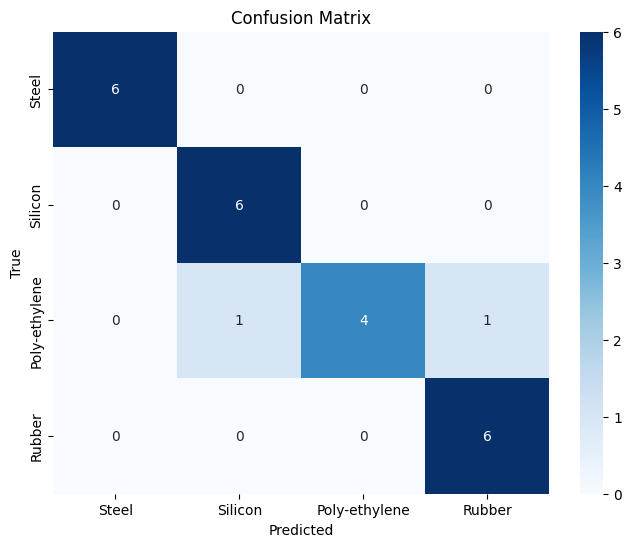

In [52]:
test_pred_tf = model.predict(test_data_tf)

# print(test_pred_tf.shape)
# print(test_labels_tf.shape)

test_pred_tf = np.argmax(test_pred_tf, axis=1)
test_labels_tf = np.argmax(test_labels_tf, axis=1)

# print(test_pred_tf.shape)
# print(test_labels_tf.shape)

classes = [0, 1, 2, 3]

cm = confusion_matrix(test_labels_tf, test_pred_tf, labels=classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Steel', 'Silicon', 'Poly-ethylene', 'Rubber'], yticklabels=['Steel', 'Silicon', 'Poly-ethylene', 'Rubber'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()